### 파일 불러오기

In [47]:
import numpy as np
import pandas as pd
df = pd.read_excel("./data/preprocessed_광진구_데이터프레임.xlsx",index_col=0)

### UMAP

In [39]:
def get_umap(df, n_neighbors, min_dist, metrics):
    '''
    n_neighbors가 작을수록 지역적 구조가 강조됨
    min_dist: 포인트 간의 거리 지정하기
    '''
    import umap
    clustering_embedding = umap.UMAP(
    n_neighbors=n_neighbors, # 5~ 50 기본값 15
    min_dist=min_dist, # 0.001~ 0.5 기본값 0.1
    n_components=2,
    random_state=42,
    metric = metrics
    ).fit_transform(df.values)
    return clustering_embedding # 100, 0.005

### HDBSCAN 클러스터링

In [40]:
def get_hdbscan(embedding, min_cluster_size, min_samples):
    '''
    min_cluster_size(군집의 최소 크기)와 min_samples(노이즈로 간주되는 최소 점의 수)만 인자로 받아서
    hdbscan진행하기
    '''
    import hdbscan
    labels = hdbscan.HDBSCAN(
    algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40,
    metric='euclidean', min_cluster_size=min_cluster_size, min_samples=min_samples
    ).fit_predict(embedding)
    return labels # 800~1000

In [41]:
def get_all_cluster(embedding,labels):
    import matplotlib.pyplot as plt
    # 노이즈 포인트 다 포함
    plt.scatter(embedding[:, 0], embedding[:, 1],
                c=labels,s=0.1, cmap='Spectral')
    plt.show()
def get_noise_cluster(embedding,labels):
    import matplotlib.pyplot as plt
    # 노이즈 포인트만
    clustered = (labels >= 0)
    plt.scatter(embedding[~clustered, 0],
                embedding[~clustered, 1],
                color=(0.5, 0.5, 0.5),
                s=0.1,
                alpha=0.5)
    plt.show()
def get_cluster(embedding,labels):
    import matplotlib.pyplot as plt
    # 노이즈 포인트 제외
    clustered = (labels >= 0)
    plt.scatter(embedding[clustered, 0],
                embedding[clustered, 1],
                c=labels[clustered],
                s=0.1,
                cmap='Spectral')
    plt.show()

In [42]:
pd.options.display.float_format = '{:.5f}'.format

### MinMax 스케일링 해보기

In [6]:
def get_scaler(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(data=scaled_df, index=df.index, columns=df.columns)
    return scaled_df

### Standard 스케일링 해보기

In [7]:
def get_standard_scaler(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(data=scaled_df, index=df.index, columns=df.columns)
    return scaled_df

### 로버스트 스케일러 해보기

In [8]:
def get_robust_scaler(df):
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    scaled_df = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(data=scaled_df, index=df.index, columns=df.columns)
    return scaled_df

### 군집화 평가 점수 

#### 군집화 평가 지수를 추출하기 위한 데이터프레임 만들기

In [43]:
def get_umap_df(df,embedding,labels):
    '''
    embedding: umap을 사용한 결과
    df: 기존 데이터프레임
    을 받아와서 umap 결과와 라벨을 받아오는 데이터프레임을 리턴하는 함수입니다.
    '''
    umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=df.index)
    umap_df["label"] = labels
    return umap_df

#### 1) 노이즈 제거 클러스터링 결과 (get_without_noise_optics)
- 실루엣 점수 : 클러스터의 밀집도와 분리도를 모두 고려하여 평가하는 지표
- 범위는 -1 ~ 1
- 1에 가까울수록 좋은 군집화 결과를 나타냄

In [44]:
def silhouette(clustering_result) : 
    from sklearn.metrics import silhouette_score

    # 클러스터링 결과에서 노이즈 포인트 제외한 데이터와 클러스터 레이 추출
    X = clustering_result[['UMAP1', 'UMAP2']]
    labels = clustering_result['label']

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, labels)

    return silhouette_avg

#### Dunn 지수 (군집화의 일관성) :

- 군집 내의 응집도와 군집 간 분리도를 모두 고려하여 군집화의 품질을 평가
- 클러스터 내 거리와 클러스터 간 거리의 비율을 이용해 계산
- Dunn 지수: Dunn 지수가 0.7 이상 = 잘 분리된 클러스터가 형성 => 클러스터링 결과가 좋다고 평가
                    = Dunn 지수가 작다는 것은 각 클러스터 간의 거리가 가깝지 않다

In [45]:
# Dunn 지수 계산 함수
def dunn(clustering_result):
    from sklearn.metrics import davies_bouldin_score
    from sklearn.neighbors import DistanceMetric
    dist = DistanceMetric.get_metric('euclidean')
    labels = clustering_result['label']
    clusters = np.unique(labels)
    centroids = [np.mean(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']], axis=0) for i in clusters]
    max_intracluster_distances = [np.max(dist.pairwise(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']])) for i in clusters]
    min_intercluster_distances = []
    for i, c1 in enumerate(centroids):
        for j, c2 in enumerate(centroids):
            if i < j:
                dist_ij = dist.pairwise([c1, c2])[0][1]
                min_intercluster_distances.append(dist_ij)
    return np.min(min_intercluster_distances) / np.max(max_intracluster_distances)

#### Calinski-Harabasz 지수 (군집화의 분리력) :

- 군집화 결과가 실제로 잘 분리되어 있는지를 판단하는 지표
- 각 군집의 분산이 커질수록, 각 군집 간의 거리가 멀어질수록 높은 값

In [46]:
# Calinski-Harabasz 지수 계산 함수
def calinski_harabasz(clustering_result):
    from sklearn.metrics import calinski_harabasz_score
    labels = clustering_result['label']
    return calinski_harabasz_score(clustering_result[['UMAP1', 'UMAP2']], labels)

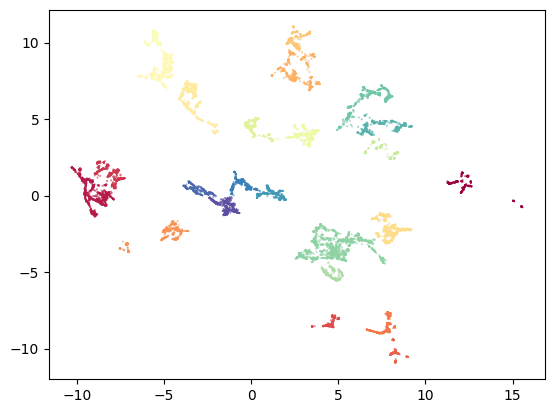

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.52479166 0.3045200490580045 49673.263200389796 300


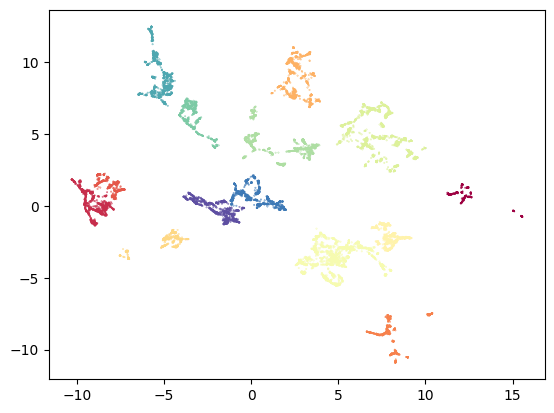

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5306737 0.2900521796129205 40721.089603970664 500


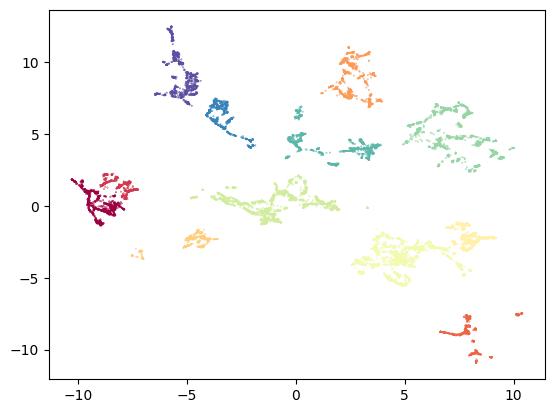

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.52931035 0.1992581949303274 38541.0443255027 600


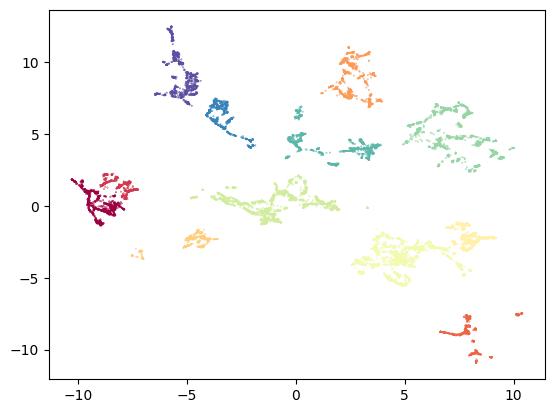

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.52931035 0.1992581949303274 38541.0443255027 700


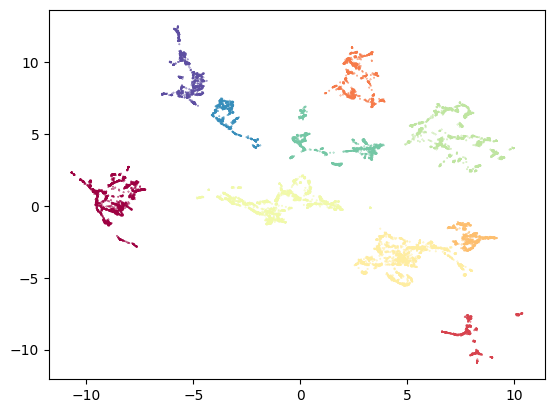

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5763256 0.43978639277445336 42803.36791194775 800


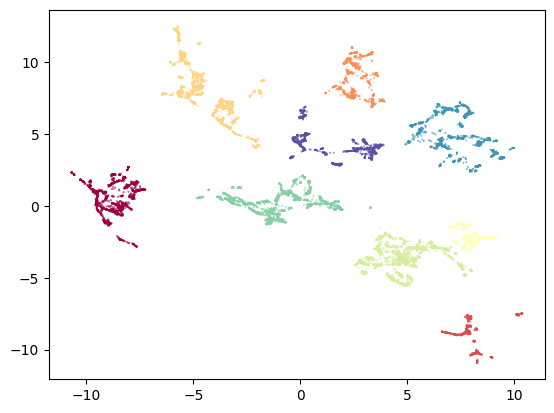

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.58522964 0.38999652375430555 39982.39076674586 900


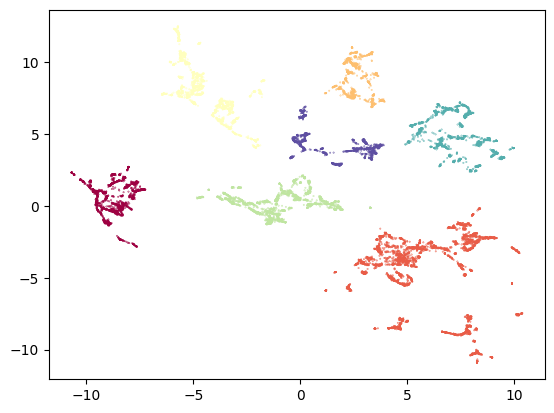

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.561494 0.4397118201438995 27574.88129968072 1000


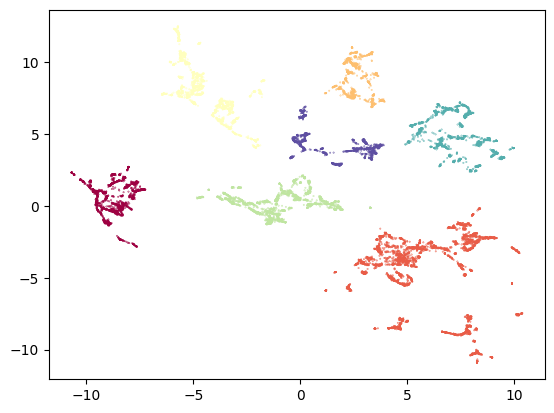

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.561494 0.4397118201438995 27574.88129968072 1100


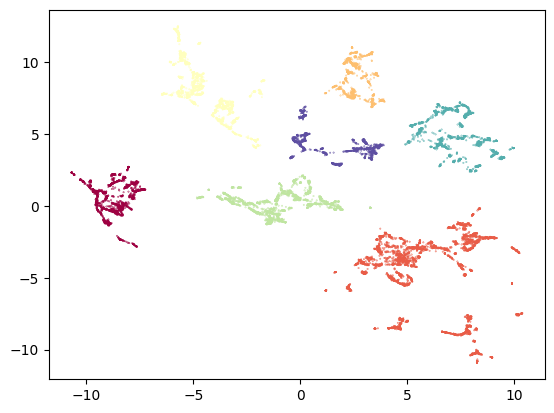

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.561494 0.4397118201438995 27574.88129968072 1200


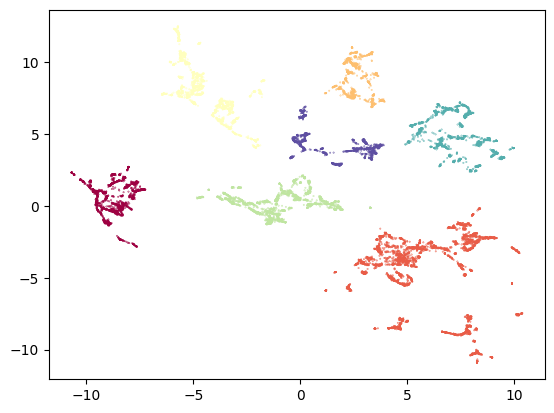

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.561494 0.4397118201438995 27574.88129968072 1300


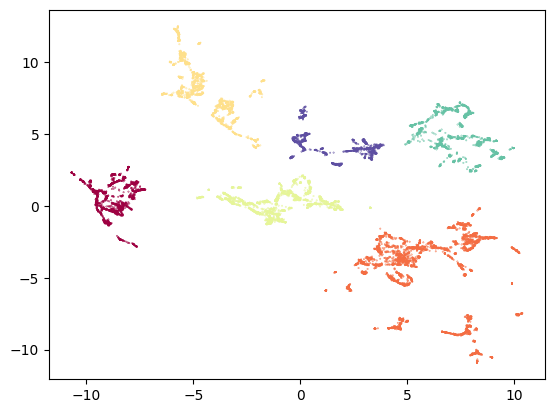

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5616653 0.4397118201438995 28530.613398585974 1400


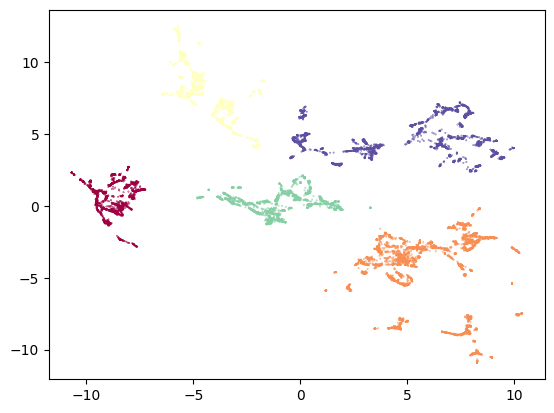

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5540177 0.6966892829993154 26600.28752988486 1500


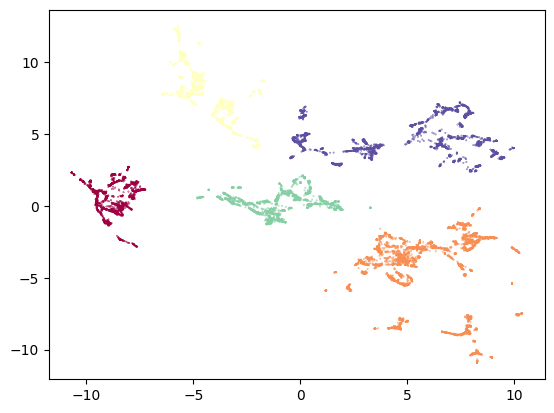

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5540177 0.6966892829993154 26600.28752988486 1600


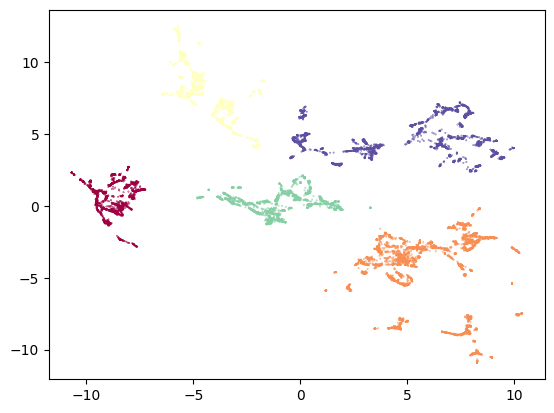

None


c:\Users\gihun\Python_Data\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


0.5540177 0.6966892829993154 26600.28752988486 1700


In [57]:
neighbor = [50, 75, 100]
clu_size= [300, 500, 600, 700, 800, 900, 1000, 1100 ,1200, 1300, 1400 ,1500, 1600, 1700]
umap_embedding = get_umap(df, 110, 0.000, 'euclidean')
for i in clu_size:
    labels = get_hdbscan(umap_embedding, i, 5)
    print(get_cluster(umap_embedding,labels))
    umap_df = get_umap_df(df,umap_embedding,labels)
    print(silhouette(umap_df[umap_df['label'] != -1]), dunn(umap_df[umap_df['label'] != -1]), calinski_harabasz(umap_df[umap_df['label'] != -1]), i)
    # 데이터프레임으로 저장하기
    silhouette_scores.append(silhouette(umap_df[umap_df['label'] != -1]))
    dunn_scores.append(dunn(umap_df[umap_df['label'] != -1]))
    calinski_harabasz_scores.append(calinski_harabasz(umap_df[umap_df['label'] != -1]))
    

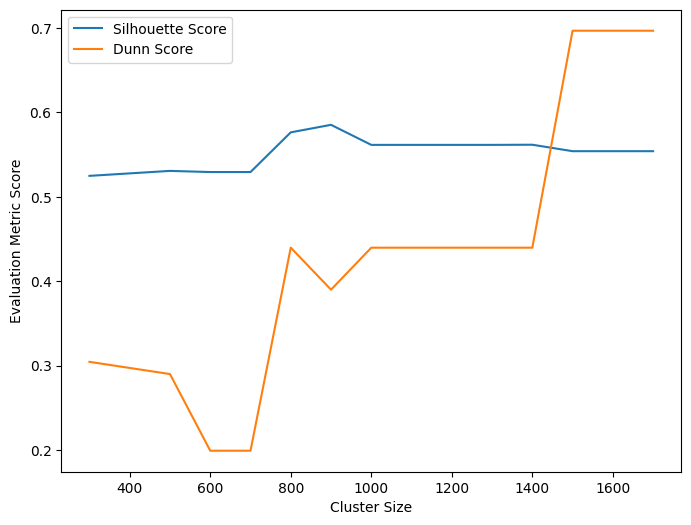

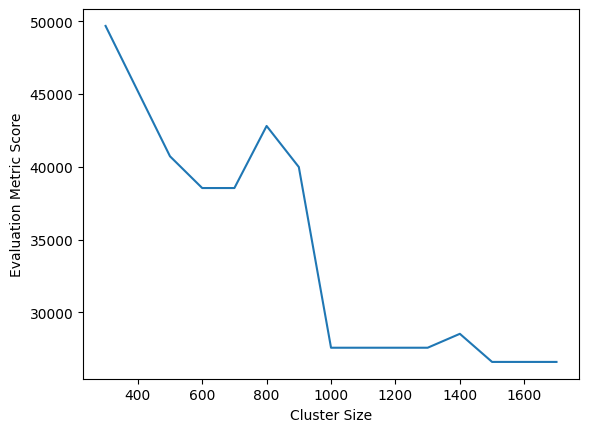

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(eval_df['Cluster Size'], eval_df['Silhouette Score'], label='Silhouette Score')
ax.plot(eval_df['Cluster Size'], eval_df['Dunn Score'], label='Dunn Score')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Evaluation Metric Score')
ax.legend()
plt.show()
plt.plot(eval_df['Cluster Size'], eval_df['Calinski-Harabasz Score'], label='Calinski-Harabasz Score')
plt.xlabel('Cluster Size')
plt.ylabel('Evaluation Metric Score')
plt.show()